# DoE - One-way ANOVA
The purpose of this notebook is to show you an example of how to apply the DoE technique called one-way Analysis of Variance (ANOVA). It uses the same scenario as the basis notebook.

In [1]:
import random
import pandas as pd
import HEMS_sim

In [2]:
# Dictionary with basic configuration of the simulation

basic_conf = {
    'ID':'00',
    'batt_storage_capacity':20,
    'batt_charge_capacity':5,
    'pv1_scaling':1,
    'controller_change_rate':0.5,
    'climate_conditions':'sunny',
    'season':'autumn',
    'random_weather':False,
    'stochastic':True,
    'noise_scale':1}

In [3]:
# Scenario name which determines the name of the files we will be saving with the results
scenario_name = 'with_noise_2'

variations = {'run_01': {'ID':'01','batt_storage_capacity':15,'controller_change_rate':0.3,
                         'season': 'summer'},
              'run_02': {'ID':'02','batt_storage_capacity':25,'controller_change_rate':0.3,
                         'season': 'summer'},
              'run_03': {'ID':'03','batt_storage_capacity':15,'controller_change_rate':0.7,
                         'season': 'summer'},
              'run_04': {'ID':'04','batt_storage_capacity':25,'controller_change_rate':0.7,
                         'season': 'summer'}}
              

# Merging of the basic configuration and the variations
recipes = {key: basic_conf.copy() for key in variations}
recipes = {key: {**recipes[key],**data} for key,data in variations.items()}


In [7]:
%%capture --no-stderr
# Suppress output from running scenarios (Prevents massive size of notebooks)
for recipe in recipes:
    HEMS_sim.run_simulation(scenario_name,recipes[recipe])

## ANOVA
In the first cell below, we load the summary statistics. We are going to analyse the self-consumption index. This is done using the ``stats`` module of the ``scipy`` library in the second cell below. See the [associated presentation](doe_erigrid_dtu_summerschool_2018-08-28.pdf) for an explanation of what ANOVA is

In [11]:
run_store = pd.HDFStore('temp_files/runs_summary_{}.h5'.format(scenario_name))
summary_1 = run_store[run_store.keys()[0]]
summary_2 = run_store[run_store.keys()[1]]
summary_3 = run_store[run_store.keys()[2]]
summary_4 = run_store[run_store.keys()[3]]
run_store.close()

sci1 = summary_1['Self consumption index'].values[0]
sci2 = summary_2['Self consumption index'].values[0]
sci3 = summary_3['Self consumption index'].values[0]
sci4 = summary_4['Self consumption index'].values[0]
summary_1

,ID,Energy bill [DKK/kWh],Max. in-feed [kW],Energy Imported [kWh],Energy exported [kWh],Self consumption index,pv1_capacity [kW],battery storage capacity [kWh],battery charge capacity[kW],climate_conditions,controller_change_rate,season,File ID/dataframe
0,01,1.090256,7.411807,2.795528,-26.55005,0.326251,1,15,5,sunny,0.3,summer,with_noise_2/timeseries/sim_01


In [12]:
from scipy import stats
Fa, pa = stats.f_oneway([sci1, sci3], [sci2, sci4])
Fb, pb = stats.f_oneway([sci1, sci2], [sci3, sci4])
Fab, pab = stats.f_oneway([sci1, sci4], [sci2, sci3])
print(sci1, sci2, sci3, sci4)
print(Fa, Fb, Fab)
print(pa, pb, pab)

0.32625115658005654 0.44977180886861956 0.3326812346976705 0.4415550382746309
496.1103810390756 0.00011774876930990059 0.007944035776209857
0.002009606408445189 0.9923272613321021 0.9371008475390368


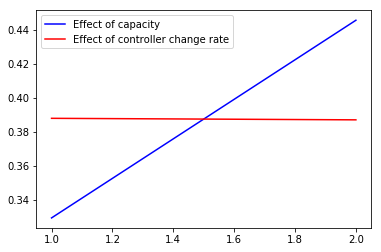

In [15]:
import matplotlib.pyplot as plt
plt.plot([1, 2], [(sci1+sci3)/2, (sci2+sci4)/2], 'b-', label="Effect of capacity")
plt.plot([1, 2], [(sci1+sci2)/2, (sci3+sci4)/2], 'r-', label="Effect of controller change rate")
plt.legend()